In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/houkong-moai/customer_churn.csv


In [41]:
data_path = "/kaggle/input/houkong-moai/customer_churn.csv"
df = pd.read_csv(data_path)
print(df.head())

   customer_id  age  gender  subscription_length  monthly_bill  total_usage  \
0            1   56    Male                   34     68.184323  2234.401392   
1            2   69    Male                   12     78.560630  1057.299270   
2            3   46  Female                    9     51.998111   452.730903   
3            4   32  Female                   15     52.919232   792.956198   
4            5   60  Female                   25     40.713593  1196.733704   

   service_complaints  churn  
0                   2      1  
1                   0      1  
2                   1      1  
3                   1      1  
4                   0      0  


In [42]:
from sklearn.impute import SimpleImputer
# 处理分类特征
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
# 删除无关列
df.drop('customer_id', axis=1, inplace=True, errors='ignore')
# 均值填充缺失值
numeric_cols = ['age', 'subscription_length', 'monthly_bill', 'total_usage', 'service_complaints']
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [43]:
from sklearn.model_selection import train_test_split

X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 初始化模型
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

# 训练模型
for name, model in models.items():
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train, y_train)  # 树模型不需要标准化

In [46]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

results = []
for name, model in models.items():
    if name == "Logistic Regression":
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  F1 Score   ROC AUC
0  Logistic Regression  0.886667  0.935361  0.912768
1        Random Forest  0.866667  0.924812  0.872817
2              XGBoost  0.853333  0.916350  0.857569


In [47]:
from sklearn.model_selection import GridSearchCV

# 选择性能最好的模型（假设是Random Forest）
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


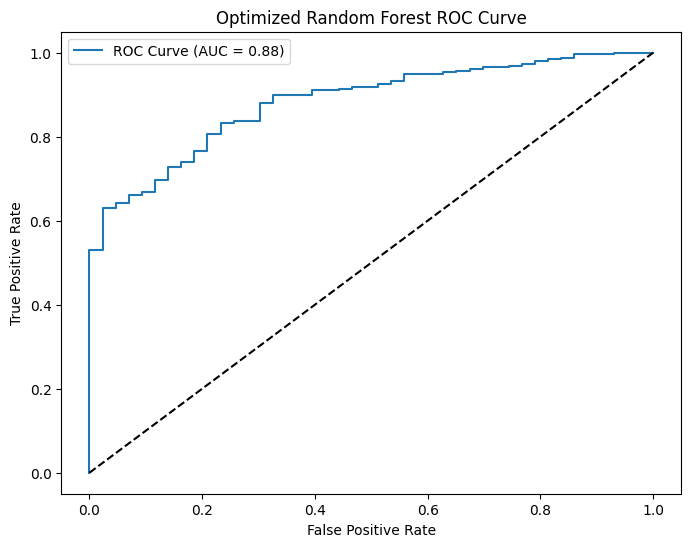

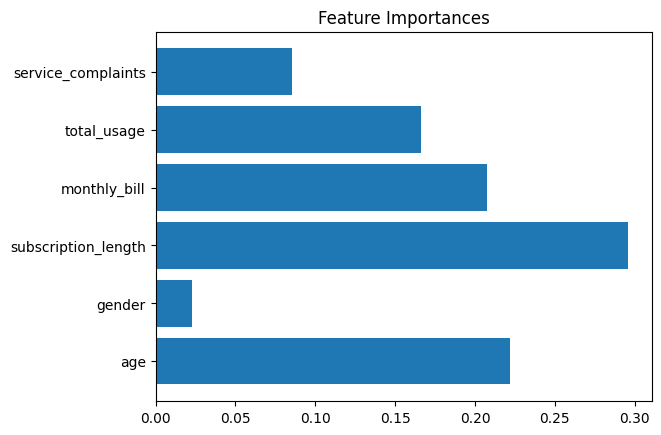

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# 预测测试集
y_prob = best_model.predict_proba(X_test)[:, 1]

# ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized Random Forest ROC Curve')
plt.legend()
plt.show()

# 特征重要性
importances = best_model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.title('Feature Importances')
plt.show()

In [49]:
from sklearn.ensemble import RandomForestClassifier

# 使用之前找到的最佳参数
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [50]:
import pandas as pd

# 加载训练数据（用于训练模型）
train_df = pd.read_csv("/kaggle/input/houkong-moai/customer_churn.csv")

# 加载测试数据（用于预测）
test_df = pd.read_csv("/kaggle/input/houkong-moai/customer_churn.csv")  # 确保文件名正确
# 假设 preprocessor 是你在训练时定义的特征处理器
X_test = preprocessor.transform(test_df)  # 预处理测试集
test_predictions = clf.predict(X_test)    # 用训练好的模型 clf 预测
submission = pd.DataFrame({
    'customer_id': test_df['customer_id'],  # 确保列名正确
    'Churn': test_predictions
})

# 保存为 submission.csv
submission.to_csv("/kaggle/working/submission.csv", index=False)
print("文件已保存！")

NameError: name 'preprocessor' is not defined